In [1]:
suppressMessages({
library(Seurat)
library(tidyverse)
library(ggpubr)
library(viridis)
library(cowplot)
library(xlsx)
dotenv::load_dot_env()
})

In [2]:
# install.packages("rdist")

In [2]:
PDIR = Sys.getenv("PROJECT_DIR")
srobj = readRDS(file.path(PDIR, "MloidDeepDive/srobj_calcUMAP.rds"))

In [3]:
umapcoords = readRDS(file.path(PDIR, "MloidDeepDive/umapcoords.rds")) #

In [4]:
srobj$umapX = umapcoords[umapcoords$mindist==0.1, c("cellID","umapX")] %>% column_to_rownames("cellID")
srobj$umapY = umapcoords[umapcoords$mindist==0.1, c("cellID","umapY")] %>% column_to_rownames("cellID")

In [5]:
OUTDIR = file.path(PDIR, "MloidDeepDive")

In [6]:
srobj

An object of class Seurat 
41715 features across 10134 samples within 2 assays 
Active assay: SCT (17970 features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, tsne, pca_coregenes, umap

In [15]:
disease.severity.colors = c("NM"="#757575","NOA"="#32c4db","PR"="#db324c","RESP"="#fcc603")

# A - psuedotime umap

In [16]:
IQR = function(x) {x[quantile(x, 0.25) <= x & x <= quantile(x, 0.75)]}
labeldat = srobj@meta.data %>% 
    group_by(curatedname) %>% 
    summarize(umapX = median(IQR(umapX)),
              umapY = median(IQR(umapY)))

options(repr.plot.height=10, repr.plot.width=10)
p1 = ggplot(srobj@meta.data) +
    geom_point(aes(x=umapX, y=umapY, color=antiTNF_response), alpha=.5) +
    ggrepel::geom_text_repel(data = labeldat, aes(x=umapX, y=umapY, label=curatedname), size=4) +
    scale_color_manual(values=disease.severity.colors) +
#     scale_color_viridis(option="plasma") +
    theme_void()

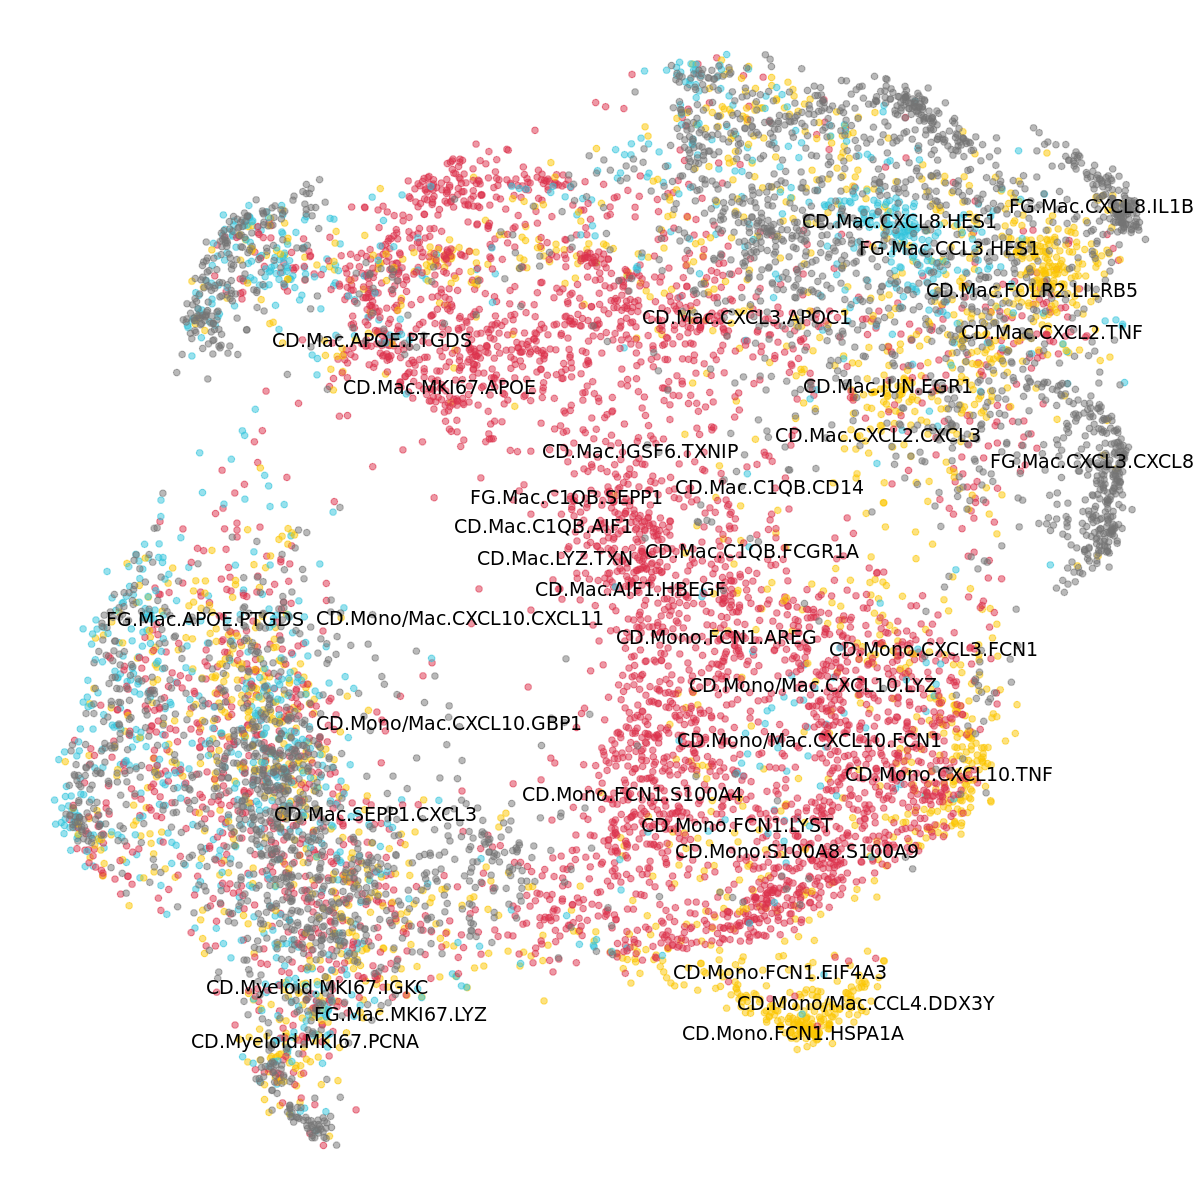

In [17]:
p1 + NoLegend()

In [13]:
ggsave(plot=p1 + NoLegend(), 
       file=file.path(OUTDIR, "A_mphages_dimplot_pseudotime.pdf"), 
       useDingbats=FALSE,
       height=10, width=10
      )
ggsave(plot=as_ggplot(get_legend(p1)),
       file=file.path(OUTDIR, "A_mphages_dimplot_legend.pdf"),
       useDingbats=FALSE,
       height=4, width=4
      )

In [18]:
# only FGID
IQR = function(x) {x[quantile(x, 0.25) <= x & x <= quantile(x, 0.75)]}
labeldat = srobj@meta.data %>%
    filter(antiTNF_response == "NM") %>%
    group_by(curatedname) %>% 
    summarize(umapX = median(IQR(umapX)),
              umapY = median(IQR(umapY)))

options(repr.plot.height=10, repr.plot.width=10)
p1 = ggplot(srobj@meta.data %>% filter(antiTNF_response == "NM")) +
    geom_point(aes(x=umapX, y=umapY, color=antiTNF_response), alpha=.5) + # color="#0433FF",
    ggrepel::geom_text_repel(data = labeldat, aes(x=umapX, y=umapY, label=curatedname), size=4) +
    scale_color_manual(values=disease.severity.colors) +
#     scale_color_viridis(option="plasma") +
    theme_void()

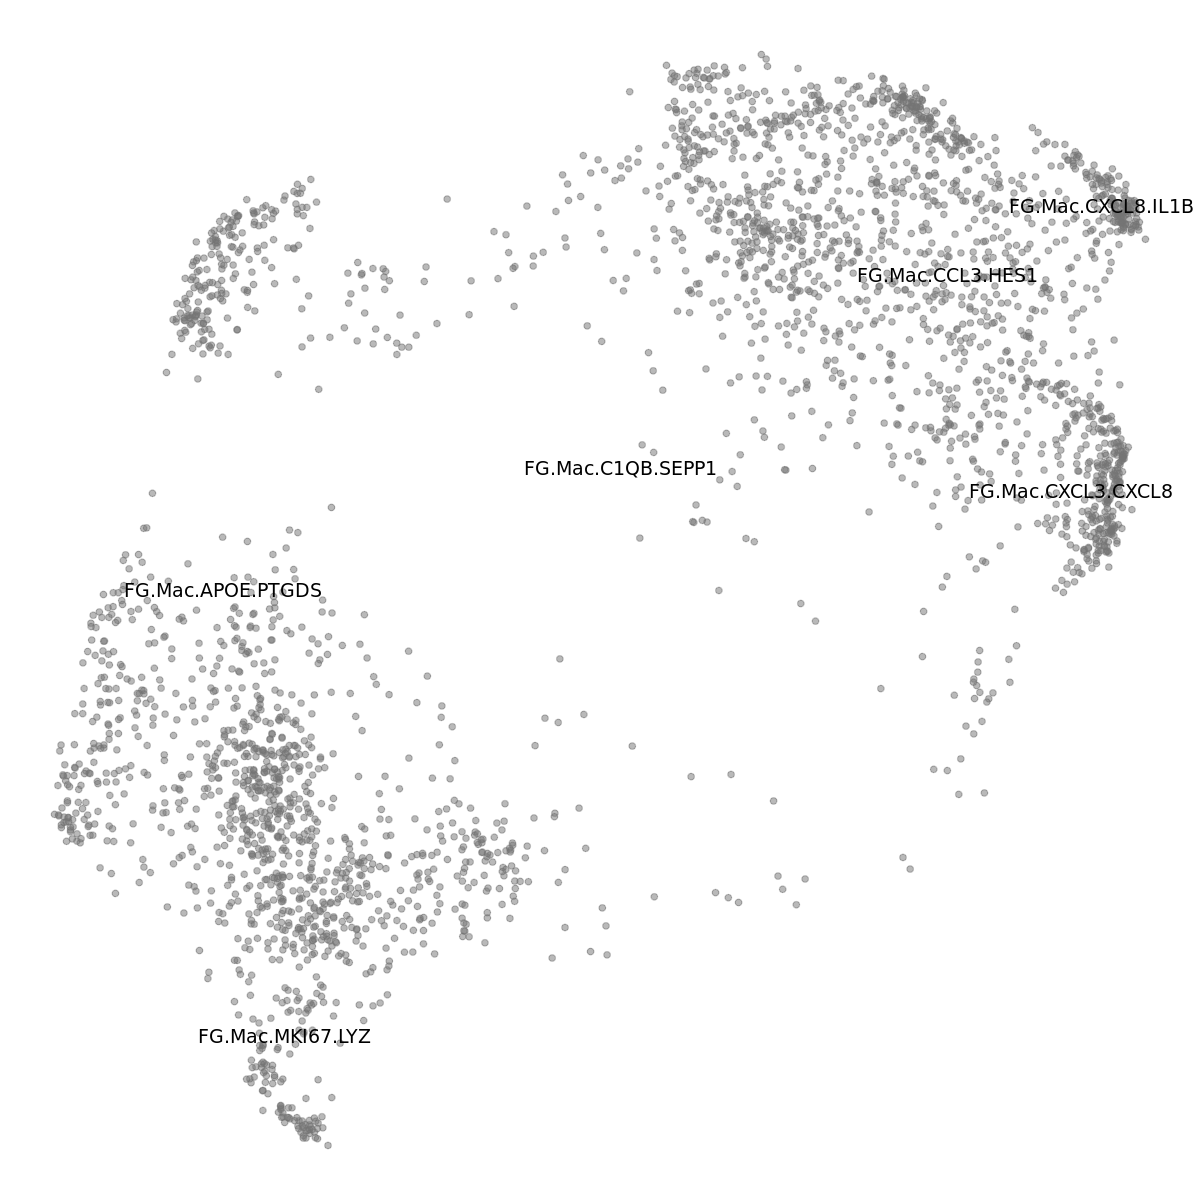

In [19]:
p1 + NoLegend()

In [20]:
ggsave(plot=p1 + NoLegend(), 
       file=file.path(OUTDIR, "A_mphages_FG_dimplot_pseudotime.pdf"), 
       useDingbats=FALSE,
       height=10, width=10
      )
ggsave(plot=as_ggplot(get_legend(p1)),
       file=file.path(OUTDIR, "A_mphages_FG_dimplot_legend.pdf"),
       useDingbats=FALSE,
       height=4, width=4
      )

In [21]:
# only CD
IQR = function(x) {x[quantile(x, 0.25) <= x & x <= quantile(x, 0.75)]}
labeldat = srobj@meta.data %>%
    filter(antiTNF_response != "NM") %>%
    group_by(curatedname) %>% 
    summarize(umapX = median(IQR(umapX)),
              umapY = median(IQR(umapY)))

options(repr.plot.height=10, repr.plot.width=10)
p1 = ggplot(srobj@meta.data %>% filter(antiTNF_response != "NM")) +
    geom_point(aes(x=umapX, y=umapY, color=antiTNF_response), alpha=.5) + # color="#FF2600",
    ggrepel::geom_text_repel(data = labeldat, aes(x=umapX, y=umapY, label=curatedname), size=4) +
    scale_color_manual(values=disease.severity.colors) +
#     scale_color_viridis(option="plasma") +
    theme_void()

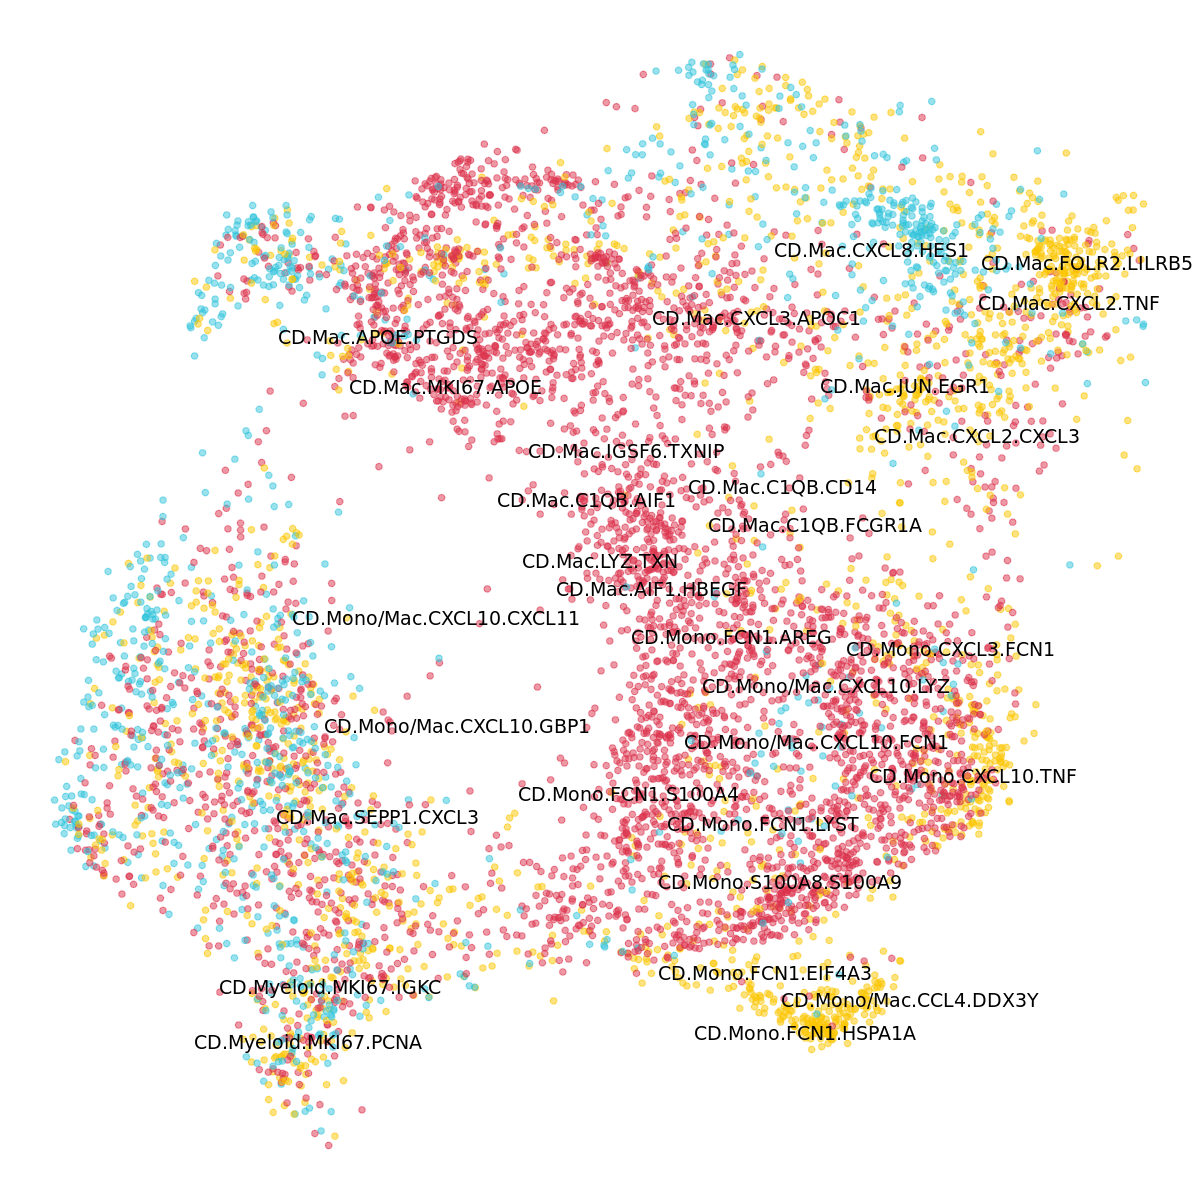

In [22]:
p1 + NoLegend()

In [23]:
ggsave(plot=p1 + NoLegend(), 
       file=file.path(OUTDIR, "A_mphages_CD_dimplot_pseudotime.pdf"), 
       useDingbats=FALSE,
       height=10, width=10
      )
ggsave(plot=as_ggplot(get_legend(p1)),
       file=file.path(OUTDIR, "A_mphages_CD_dimplot_legend.pdf"),
       useDingbats=FALSE,
       height=4, width=4
      )

# B - Feature Plot of curated genes

In [212]:
plottypes = c("CD.Mac.APOE.PTGDS", "FG.Mac.APOE.PTGDS", "CD.Myeloid.MKI67.IGKC", "FG.Mac.MKI67.LYZ",
              "FG.Mac.C1QB.SEPP1","FG.Mac.CXCL8.IL1B","FG.Mac.CXCL3.CXCL8","FG.Mac.CCL3.HES1",
              "CD.Mono/Mac.CXCL10.FCN1","CD.Mono.FCN1.S100A4",  "CD.Mac.CXCL3.APOC1", "CD.Mac.FOLR2.LILRB5"
              )
plist = list()
for (tnn in plottypes) {
#     Idents(srobj) = srobj$curatedname == tnn
    pltdat = srobj@meta.data %>% mutate(TNN = curatedname == tnn)
    plist[[tnn]] = ggplot(pltdat) +
        geom_point(data = pltdat[pltdat$TNN == FALSE,], 
                   aes(x=umapX, y=umapY), alpha=.3, color="gray", size=0.1) +
        geom_point(data = pltdat[pltdat$TNN == TRUE,],
                   aes(x=umapX, y=umapY), alpha=.5, color="black", size=0.2) +
        ggtitle(tnn) +
        theme_void() +
        NoLegend()
}

options(repr.plot.height = 11, repr.plot.width=11)
p = ggarrange(plotlist=plist, align="hv")

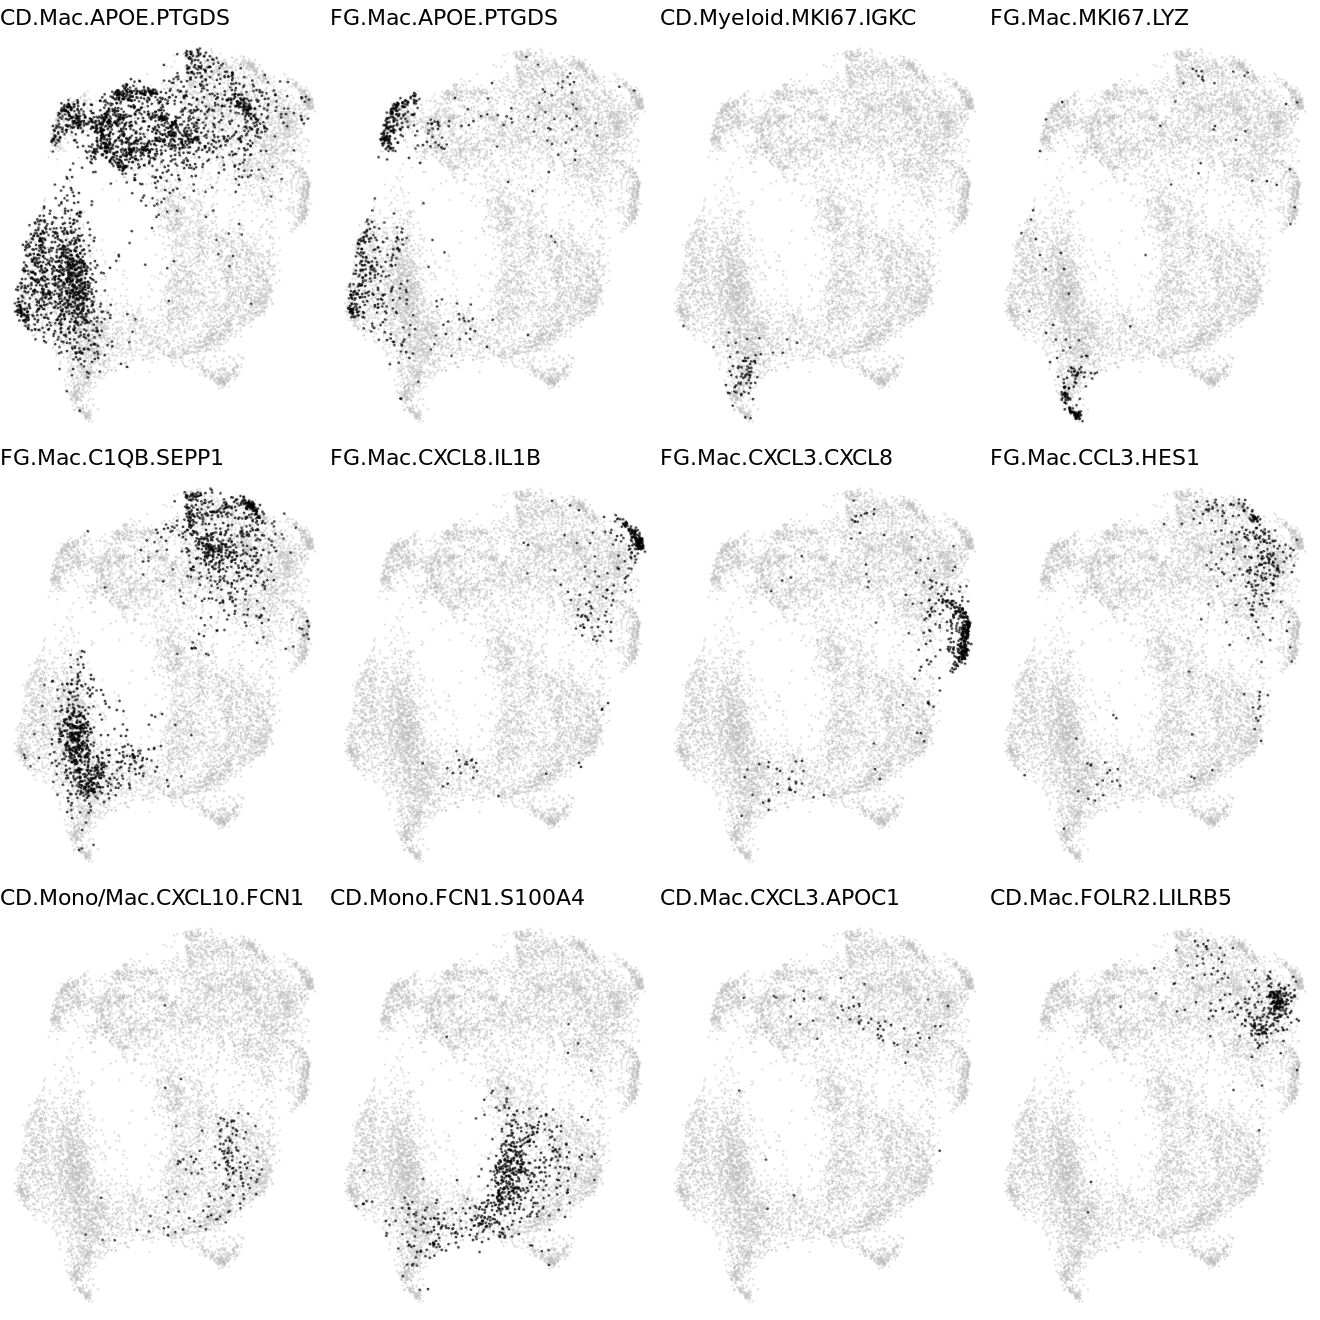

In [213]:
p

In [35]:
plottypes = c("CD.Mono.FCN1.S100A4",
              "CD.Mono.CXCL3.FCN1", 
              "CD.Mono/Mac.CXCL10.FCN1",
              "CD.Mac.CXCL3.APOC1",
              "CD.Mac.C1QB.CD14")
plist = list()
for (tnn in plottypes) {
#     Idents(srobj) = srobj$curatedname == tnn
    pltdat = srobj@meta.data %>% mutate(TNN = curatedname == tnn)
    plist[[tnn]] = ggplot(pltdat) +
        geom_point(data = pltdat[pltdat$TNN == FALSE,], 
                   aes(x=umapX, y=umapY), alpha=.3, color="gray", size=0.1) +
        geom_point(data = pltdat[pltdat$TNN == TRUE,],
                   aes(x=umapX, y=umapY), alpha=.5, color="black", size=0.2) +
        ggtitle(tnn) +
        theme_void() +
        NoLegend()
}

options(repr.plot.height = 10, repr.plot.width=3)
p = ggarrange(plotlist=plist, ncol=1)

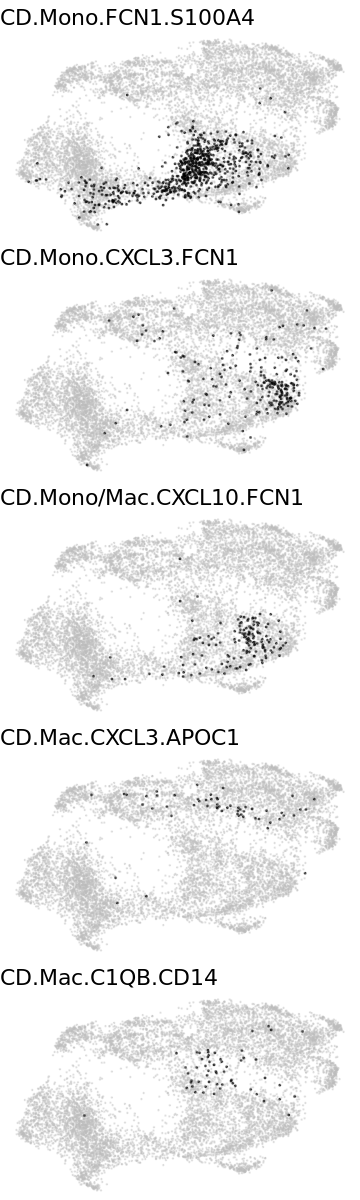

In [36]:
p

In [37]:
ggsave(plot=p, 
       file=file.path(OUTDIR, "B_mphage_subsetumapplots_1column.pdf"), 
       useDingbats=FALSE,
       height=10, width=3
      )

# C - umap distribution in psudotime

In [29]:
get_contour = function(df) {
    fhat = ks::kde(df[, c("x", "y")], compute.cont=TRUE)
    dimnames(fhat[['estimate']]) <- list(fhat[["eval.points"]][[1]], fhat[["eval.points"]][[2]])
    contours = reshape2::melt(fhat[["estimate"]])
    contours$quantile = fhat[["cont"]]["5%"]
    return(contours)
}

hpd_contour <- function (x, n = 50, prob = 0.95, ...) {
  post1 <- MASS::kde2d(x[[1]], x[[2]], n = n, ...)

  dx <- diff(post1$x[1:2])
  dy <- diff(post1$y[1:2])
  sz <- sort(post1$z)
  c1 <- cumsum(sz) * dx * dy

  levels <- sapply(prob, function(x) {
    approx(c1, sz, xout = 1 - x)$y
  })

  return(data.table::rbindlist(grDevices::contourLines(post1$x, post1$y, post1$z, levels = levels), idcol="sbgrp"))
}

In [166]:
disease.severity.colors = c("NM"="#757575","NOA"="#32c4db","PR"="#db324c","FR"="#fcc603")
options(repr.plot.width=15, repr.plot.height=5)


pltdat = srobj@meta.data
pltdat$antiTNF_response = factor(pltdat$antiTNF_response, levels=c("NM", "NOA", "RESP", "PR"))
levels(pltdat$antiTNF_response) = c("NM", "NOA", "FR", "PR")

clines = data.frame(umapX=pltdat$umapX,
                    umapY=pltdat$umapY,
                    antiTNF_response=pltdat$antiTNF_response) %>% 
  group_by(antiTNF_response) %>% 
  do(hpd_contour(.[, c("umapX", "umapY")], 
                 prob=0.8,
                 lims=c(range(-7:7), range(-5:5))))

p = ggplot(pltdat, 
       aes(x=umapX, y=umapY, color=antiTNF_response)) + 
    geom_point(size=0.5, alpha=0.2) +
#     stat_density_2d(aes(fill=antiTNF_response), geom="polygon", alpha=.3, bins=3) +
    geom_polygon(data=clines, aes(x=x, y=y,subgroup=sbgrp, fill=antiTNF_response), alpha=.3) +
    xlim(c(-7, 7)) + ylim(c(-5, 5)) +
    facet_grid(.~antiTNF_response) +
    scale_color_manual(values=disease.severity.colors) +
    scale_fill_manual(values=disease.severity.colors) +
    theme_cowplot() + 
    xlab("") + ylab("") + 
    theme(legend.position="top",
          #axis.line = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank()) 

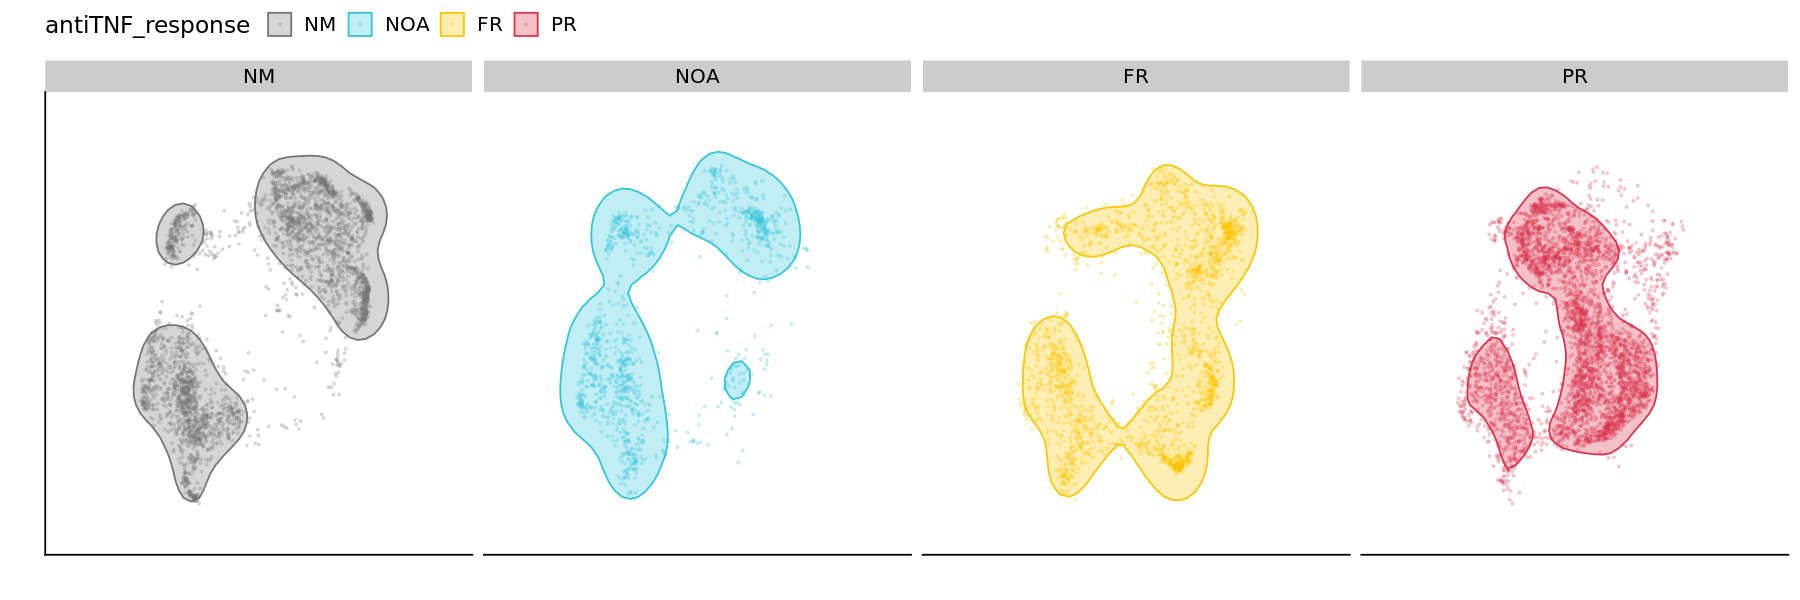

In [167]:
p

In [42]:
ggsave(plot=p + NoLegend(), 
       file=file.path(OUTDIR, "C_mphage_umap_facet_ATR.pdf"), 
       useDingbats=FALSE,
       height=4, width=15
      )
ggsave(plot=as_ggplot(get_legend(p)),
       file=file.path(OUTDIR, "C_mphage_umap_facet_legend.pdf"),
       useDingbats=FALSE,
       height=4, width=4
      )

# D - TNF

In [170]:
srobj[['umap.pseudo']] = CreateDimReducObject(
    embeddings = as.matrix(setNames(srobj@meta.data[, c("umapX", "umapY")], c("pt_1", "pt_2"))),
    key = "pt_", 
    assay = DefaultAssay(srobj))

In [ ]:
srobj$ATR = pltdat$antiTNF_response

In [117]:
options(repr.plot.height = 5, repr.plot.width=5)
p1 = FeaturePlot(srobj,"TNF", reduction="umap.pseudo") + 
    theme_void()+
    theme(legend.position="right")

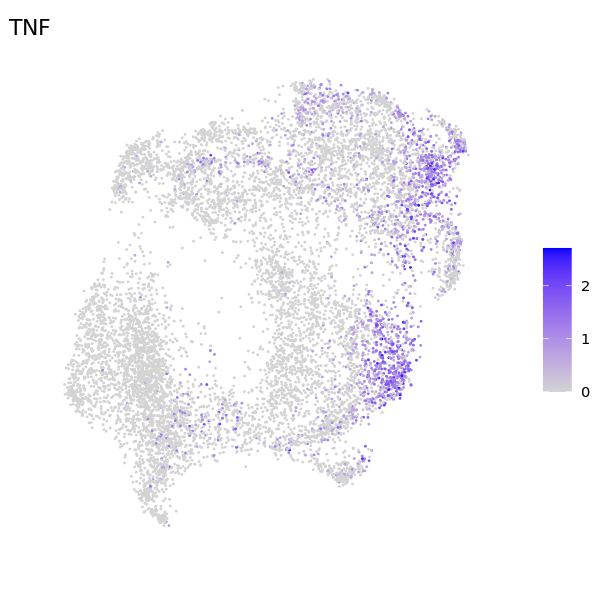

In [118]:
p1

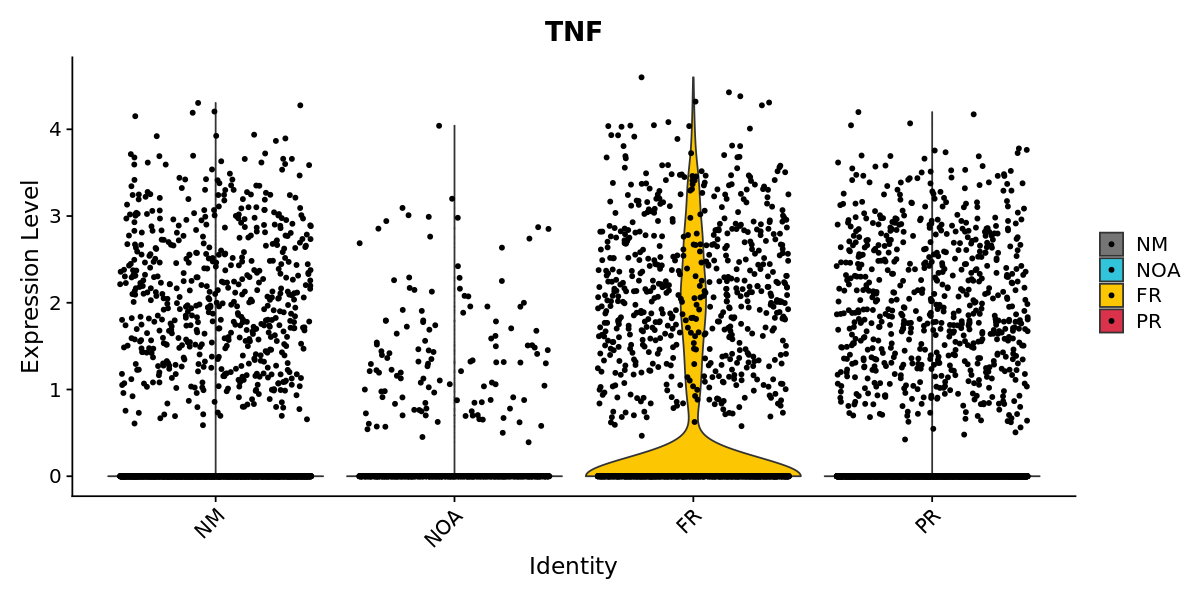

In [119]:
options(repr.plot.height = 5, repr.plot.width=10)
p2 = VlnPlot(srobj, assay="RNA", "TNF", group.by="ATR") + 
    scale_fill_manual(values=disease.severity.colors)
p2

In [51]:
# calculate probability of finding this results if TNF fraction is uniform across ATR groups
df = data.frame(ATR = srobj$ATR, TNF = srobj@assays$RNA@data["TNF", ])

pltdf = df %>% group_by(ATR) %>% summarize(TNFfrac = mean(TNF > 0))

perms = data.table::rbindlist(lapply(1:10000, function(n) {
    df %>% 
    mutate(ATR=sample(ATR, replace=FALSE)) %>% 
    group_by(ATR) %>% 
    summarize(TNFfrac = mean(TNF > 0))
}), idcol="ID")

m.sd.perms = perms %>% 
    group_by(ATR) %>%
    summarize(mean = mean(TNFfrac),
              sd = sd(TNFfrac))

In [112]:
# pvalues
signif(1 - pnorm(abs((pltdf$TNFfrac - m.sd.perms$mean) / m.sd.perms$sd)), digits=3)

[1] 2.46e-02 2.10e-12 0.00e+00 1.16e-09

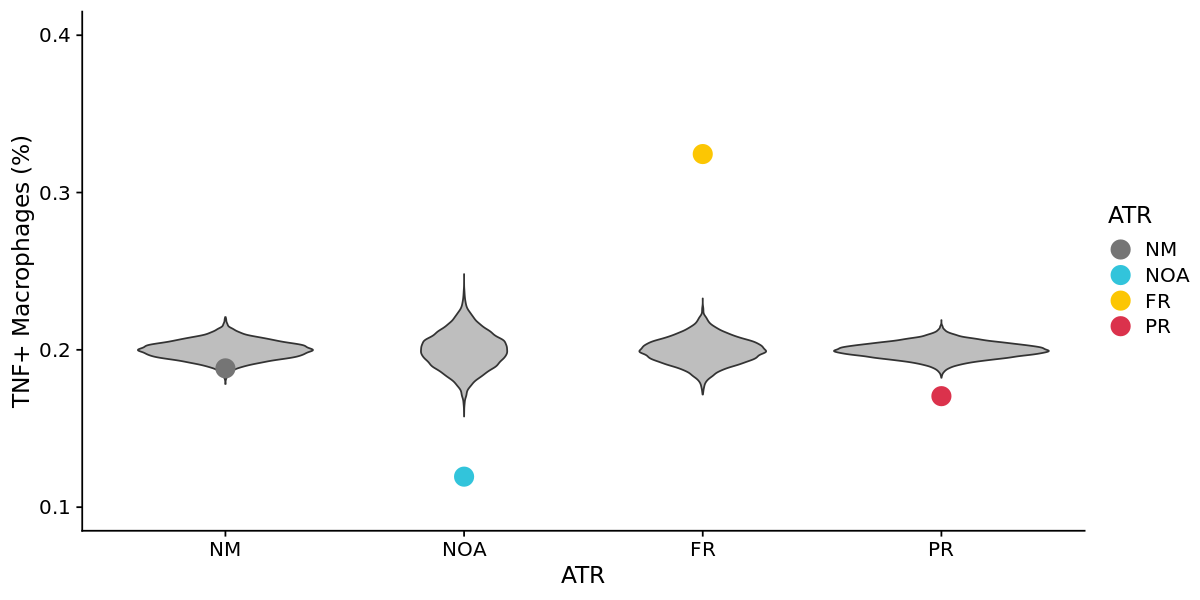

In [120]:
p3 = ggplot(perms) +
    geom_violin(aes(x=ATR, y=TNFfrac), fill="gray") +
    geom_point(data = pltdf, aes(x=ATR, y=TNFfrac, color=ATR),  size=5) +
    ylim(c(0.1, .4)) +
    scale_color_manual(values=disease.severity.colors) +
    ylab("TNF+ Macrophages (%)") +
    theme_cowplot()
p3

In [121]:
ggsave(plot=p1,
       file=file.path(OUTDIR, "D_mphage_TNF_umap.pdf"), 
       useDingbats=FALSE,
       height=5, width=5
      )

In [122]:
ggsave(plot=p2,
       file=file.path(OUTDIR, "D_mphage_TNF_violin.pdf"), 
       useDingbats=FALSE,
       height=5, width=10
      )

In [123]:
ggsave(plot=p3, 
       file=file.path(OUTDIR, "D_mphage_TNFposfraction.pdf"), 
       useDingbats=FALSE,
       height=5, width=10
      )

# E - Statistial Cell distribution

In [149]:
hellinger2d = function(psmp, qsmp, bgridsize=rep(100, dim(qsmp)[2])) {

    psmp = as.matrix(psmp)
    qsmp = as.matrix(qsmp)
    smp = rbind(psmp, qsmp)

    mins = matrixStats::colMins(smp)
    maxs = matrixStats::colMaxs(smp)
    H = ks::Hpi(smp)
    
    phat = ks::kde(psmp,
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    qhat = ks::kde(qsmp, 
                   H=H, 
                   bgridsize=bgridsize, 
                   xmin=mins, xmax=maxs, 
                   compute.cont=FALSE,
                   approx.cont=FALSE)$estimate
    
    ps = round(phat, digits=15)
    ps = ps / sum(ps) # make sum to 1
    
    qs = round(qhat, digits=15)
    qs = qs / sum(qs) # make sum to 1
    
    return(
        sqrt(1 - sum(sqrt(ps*qs)))
    )
}

In [150]:
calcCombNHellinger = function(df){
    data.table::rbindlist(parallel::mclapply(combn(c("NM", "NOA", "RESP", "PR"),2,simplify=FALSE), function(grp) {
    data.frame(grp1=grp[1], grp2=grp[2],
               dist=hellinger2d(
                    psmp=df[df$TNFR == grp[1], c("umapX", "umapY")],
                    qsmp=df[df$TNFR == grp[2], c("umapX", "umapY")]
               ))
    }))
}

In [154]:
teststats = data.table::rbindlist(lapply(unique(umapcoords$mindist), function(md) {
    df = calcCombNHellinger(umapcoords[umapcoords$mindist == md, c("TNFR", "umapX", "umapY")])
    df$mindist = md
    return(df)
}))

In [156]:
write.table(teststats, file=file.path(OUTDIR, "teststats.csv"), sep=",", row.names=FALSE)

In [163]:
teststats = read.csv(file.path(OUTDIR, "teststats.csv"))

In [170]:
# make permutations
N = 1e3
permutations = data.table::rbindlist(parallel::mclapply(1:N, function(n) {
    perm = data.table::rbindlist(lapply(unique(umapcoords$mindist), function(md) {
        pdat = umapcoords[umapcoords$mindist == md, c("TNFR", "umapX", "umapY")] %>%
            mutate(TNFR = sample(TNFR, replace = FALSE))
        df = calcCombNHellinger(pdat)
        df$mindist = md
        return(df)
    }))
    perm$permutationID = n
    return(perm)
}, mc.cores=25))

In [171]:
write.table(permutations, file=file.path(OUTDIR, "permutations.csv"), sep=",", row.names=FALSE)

In [124]:
teststats = read.csv(file.path(OUTDIR, "teststats.csv"))
permutations = read.csv(file.path(OUTDIR, "permutations.csv"))

In [125]:
permutations %>% head

grp1 grp2 dist       mindist permutationID
1 NM   NOA  0.09145512 0.01    1            
2 NM   RESP 0.08008500 0.01    1            
3 NM   PR   0.07019350 0.01    1            
4 NOA  RESP 0.09686132 0.01    1            
5 NOA  PR   0.09373878 0.01    1            
6 RESP PR   0.07404068 0.01    1

In [128]:
m.sd.permutations = pltdat %>% 
    group_by(cmp) %>%
    summarize(mean = mean(dist),
              sd = sd(dist))

In [129]:
m.sd.permutations

cmp       mean       sd         
1 NMvsNOA   0.09009862 0.009679804
2 NMvsPR    0.06971973 0.007557368
3 NMvsRESP  0.07738283 0.008407446
4 NOAvsPR   0.09208836 0.009876031
5 NOAvsRESP 0.08875362 0.009646549
6 RESPvsPR  0.07722899 0.008324262

In [126]:
pltdat = permutations %>% mutate(cmp = paste0(grp1, "vs", grp2))

In [127]:
tstdat = teststats %>% mutate(cmp = paste0(grp1, "vs", grp2))

round(10^seq(-2, 0, 0.2),digits=2) # 10^-2:0.2:0


mindist = c(0.01, 0.02, 0.03, 0.04, 0.06, 0.1, 0.16, 0.25, 0.4, 0.63, 1)

In [135]:
plist = list()
for (cmp in unique(pltdat$cmp)) {
    plist[[cmp]] = ggplot(pltdat[pltdat$cmp==cmp, ]) + 
        ggtitle(cmp) +
        xlab("Hellinger Distance") +
        geom_density(aes(x=dist), fill="gray") +
        geom_density(data=tstdat[tstdat$cmp==cmp, ], aes(x=dist), fill="black") +
        geom_vline(xintercept=tstdat$dist[tstdat$cmp==cmp & tstdat$mindist==0.01]) +
#         annotate("text",.7, 50, label="p < 0.001") +
        xlim(c(0, 0.75)) +
        ylim(c(0, 60)) +
        theme_cowplot()
}

options(repr.plot.width=10, repr.plot.height=5)
p = ggarrange(plotlist=plist, align="hv")

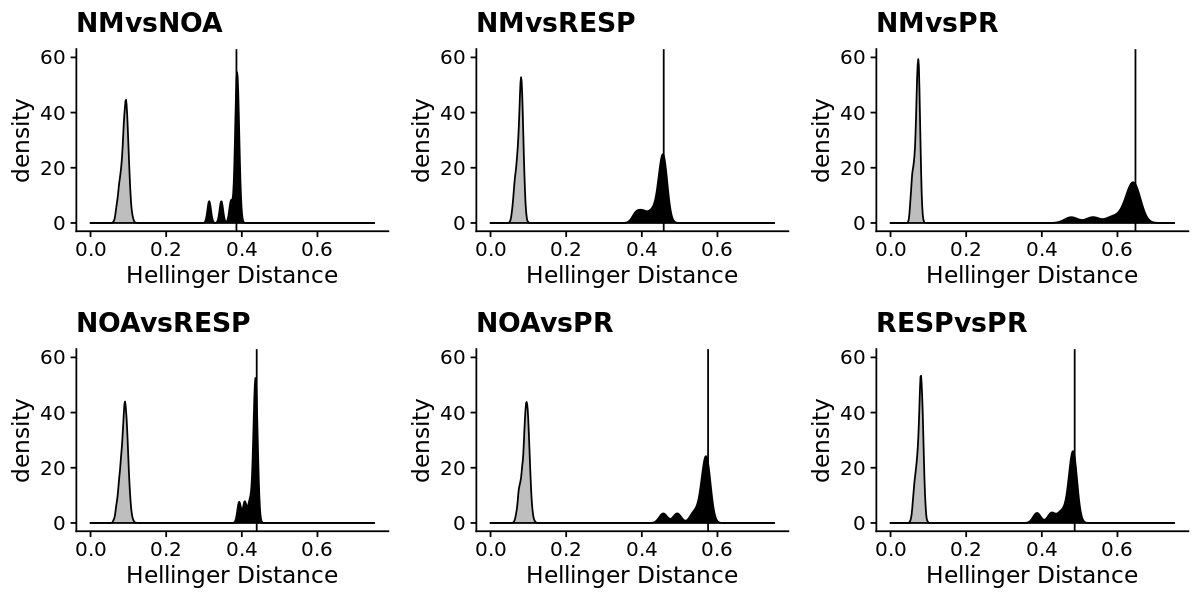

In [136]:
p

In [137]:
ggsave(plot=p, 
       file=file.path(OUTDIR, "E_mphage_HellingerDist.pdf"), 
       useDingbats=FALSE,
       height=5, width=10
      )

# G diversity cut off

In [140]:
mloid = readRDS(file.path(OUTDIR, "mloid_merged_srobj.rds"))
mloid = mloid[, !grepl("Doub|LowQual", mloid$type)]
mloid = srobj[, !grepl("DC", srobj$curatedname)]

In [141]:
pltdat = mloid@meta.data %>%
    group_by(curatedname) %>%
    summarize(patsplit = length(unique(patient)),
              patginismp = 1 - sum(((table(patient)) / (length(patient)))^2),
              disease = first(disease))

In [152]:
p1 = ggplot(pltdat) +
    geom_violin(aes(y=patginismp, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patginismp, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.03) +
    geom_hline(aes(yintercept=0.1), color='red', linetype=2) +
    scale_y_continuous(breaks=seq(0, 1, 0.1)) +
    ylab("Diversity Index") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0433FF", "#FF2600")) +
    theme_cowplot()
p2 = ggplot(pltdat) +
    geom_violin(aes(y=patsplit, x=disease, fill=disease),
                trim = FALSE,
                draw_quantiles = c(0.25, 0.5, 0.75), 
                alpha=0.6) +
    geom_dotplot(aes(y=patsplit, x=disease),
                 binaxis = "y",
                 stackdir = "center",
                 binwidth=.5) +
    scale_y_continuous(breaks=1:14) +
    ylab("N patients in subset") +
    scale_fill_manual(limits=c("FGID", "CD"),
                        labels=c("FG", "CD"),
                        values=c("#0433FF", "#FF2600")) +
    theme_cowplot()
options(repr.plot.height = 5, repr.plot.width=10)
p = ggarrange(plotlist=list(p1 + NoLegend(), p2), ncol=2)

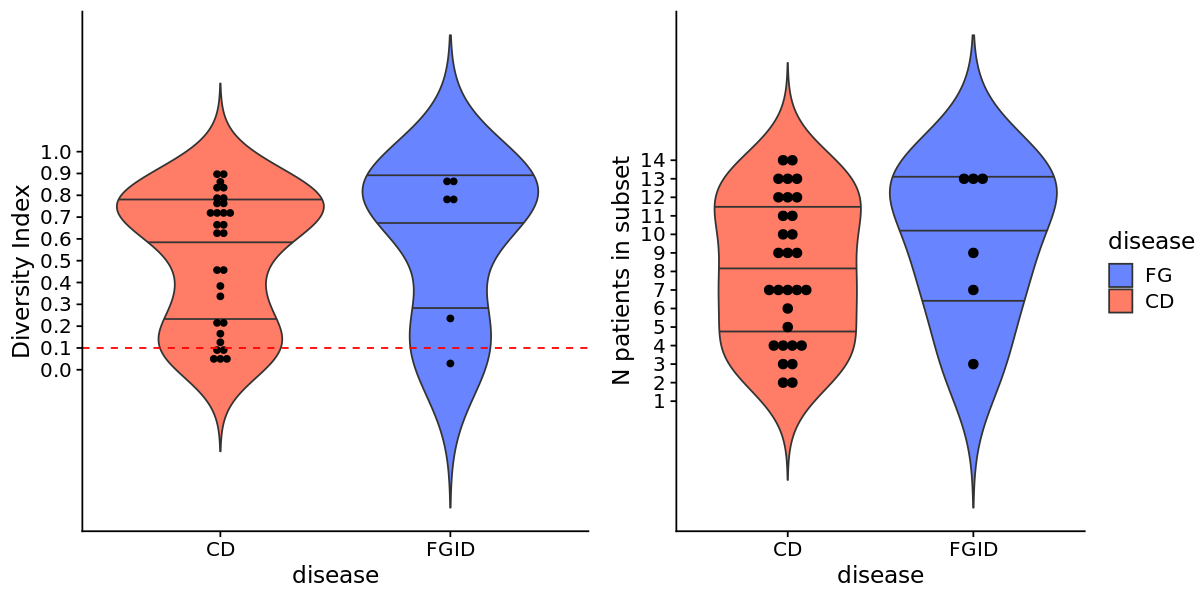

In [153]:
p

In [154]:
ggsave(plot=p, 
       file=file.path(OUTDIR, "G_mphage_filterthreshold.pdf"), 
       useDingbats=FALSE,
       height=5, width=10
      )